In [2]:
library(dplyr)
library(ggplot2)
library(ggmap)
library(data.table)
library(maptools)
library(rgdal)
options(jupyter.plot_mimetypes = 'image/png')

## Census tract data

To map data onto map at the census tract level, need to get California shapefile from census.gov. I chose cartographic boundary shapefiles for small scale mapping projects, at the 500k scale. The function readOGR() from the package rgdal can read shapefile into SpatialPolygonsDataFrame. GEOID has the unique ID for each county and will be used to join the ACS census data.

In [3]:
ca_shp = readOGR(dsn="cb_2014_06_tract_500k", layer ="cb_2014_06_tract_500k")

OGR data source with driver: ESRI Shapefile 
Source: "/Users/lingcheng/temp/sf-crime/cb_2014_06_tract_500k", layer: "cb_2014_06_tract_500k"
with 8043 features
It has 9 fields


Warning message:
In readOGR(dsn = "cb_2014_06_tract_500k", : Z-dimension discarded

In [4]:
str(ca_shp)

Formal class 'SpatialPolygonsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	8043 obs. of  9 variables:
  .. ..$ STATEFP : Factor w/ 1 level "06": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ COUNTYFP: Factor w/ 58 levels "001","003","005",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ TRACTCE : Factor w/ 6521 levels "000100","000101",..: 4411 4426 4443 4472 4473 4546 4578 4604 4642 4682 ...
  .. ..$ AFFGEOID: Factor w/ 8043 levels "1400000US06001400100",..: 3 9 15 22 23 46 59 74 87 99 ...
  .. ..$ GEOID   : Factor w/ 8043 levels "06001400100",..: 3 9 15 22 23 46 59 74 87 99 ...
  .. ..$ NAME    : Factor w/ 6521 levels "1","1.01","1.02",..: 2876 2891 2911 2945 2946 3029 3065 3106 3155 3199 ...
  .. ..$ LSAD    : Factor w/ 1 level "CT": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ ALAND   : num [1:8043] 1105329 420877 467999 318842 398820 ...
  .. ..$ AWATER  : num [1:8043] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ polygons   :List of 8043
  .. ..$ :Formal class 'Polygons' [package "sp"] with 5 slots
  .. .. 

## Poverty data from ACS

Poverty data is from ACS 'ACS_14_5YR_B17021', 5-year estimate for 2014. The first column HD01_VD01 is the total number of people in the census tract. The column HD02_VD01 is the number of people whose income in the past 12 months were below poverty level.

In [5]:
ca_data = read.csv('ACS_14_5YR_B17021/ACS_14_5YR_B17021_with_ann.csv')

In [6]:
head(ca_data)

,GEO.id,GEO.id2,GEO.display.label,HD01_VD01,HD02_VD01,HD01_VD02,HD02_VD02,HD01_VD03,HD02_VD03,HD01_VD04,ellip.h,HD01_VD34,HD02_VD34,HD01_VD35,HD02_VD35,HD01_VD37,HD02_VD37,HD01_VD38,HD02_VD38,HD01_VD39,HD02_VD39
1,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,Estimate; Income in the past 12 months below poverty level:,Margin of Error; Income in the past 12 months below poverty level:,Estimate; Income in the past 12 months below poverty level: - In family households:,Margin of Error; Income in the past 12 months below poverty level: - In family households:,Estimate; Income in the past 12 months below poverty level: - In family households: - In married couple families:,⋯,Estimate; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement:,Margin of Error; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement:,Estimate; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Householder:,Margin of Error; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Householder:,Estimate; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Householder: - Living alone,Margin of Error; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Householder: - Living alone,Estimate; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Householder: - Not living alone,Margin of Error; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Householder: - Not living alone,Estimate; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Other living arrangement,Margin of Error; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Other living arrangement
2,1400000US06075010100,06075010100,"Census Tract 101, San Francisco County, California",3807,351,547,208,121,88,51,⋯,1498,246,1188,182,909,180,279,111,310,130
3,1400000US06075010200,06075010200,"Census Tract 102, San Francisco County, California",4220,385,287,157,68,98,30,⋯,2350,323,1900,247,1456,227,444,161,450,156
4,1400000US06075010300,06075010300,"Census Tract 103, San Francisco County, California",4346,478,775,303,390,172,357,⋯,1579,338,1116,206,672,190,444,175,463,208
5,1400000US06075010400,06075010400,"Census Tract 104, San Francisco County, California",5254,587,477,315,104,122,64,⋯,2452,485,1592,278,1183,240,409,178,860,302
6,1400000US06075010500,06075010500,"Census Tract 105, San Francisco County, California",2606,215,181,115,0,12,0,⋯,961,193,859,160,783,155,76,61,102,76


In [7]:
#slice data to keep the relevant columns
ca_data = select(ca_data, GEO.id2, GEO.display.label, HD01_VD01,HD01_VD02) %>% slice(-1) 
head(ca_data)

,GEO.id2,GEO.display.label,HD01_VD01,HD01_VD02
1,06075010100,"Census Tract 101, San Francisco County, California",3807,547
2,06075010200,"Census Tract 102, San Francisco County, California",4220,287
3,06075010300,"Census Tract 103, San Francisco County, California",4346,775
4,06075010400,"Census Tract 104, San Francisco County, California",5254,477
5,06075010500,"Census Tract 105, San Francisco County, California",2606,181
6,06075010600,"Census Tract 106, San Francisco County, California",3664,1175


In [8]:
str(ca_data)

'data.frame':	197 obs. of  4 variables:
 $ GEO.id2          : Factor w/ 198 levels "06075010100",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ GEO.display.label: Factor w/ 198 levels "Census Tract 101, San Francisco County, California",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ HD01_VD01        : Factor w/ 193 levels "0","114","12149",..: 78 102 111 151 30 67 155 134 132 154 ...
 $ HD01_VD02        : Factor w/ 179 levels "0","1014","1043",..: 125 61 159 105 37 16 7 172 107 65 ...


In [9]:
#convert data type and calculate percentage
ca_data$GEO.id2 = as.character(ca_data$GEO.id2)
ca_data$GEO.display.label = as.character(ca_data$GEO.display.label)
ca_data$HD01_VD01 = as.numeric(as.character(ca_data$HD01_VD01))
ca_data$HD01_VD02 = as.numeric(as.character(ca_data$HD01_VD02))
ca_data$percent = (ca_data$HD01_VD02/ca_data$HD01_VD01)*100
head(ca_data)

,GEO.id2,GEO.display.label,HD01_VD01,HD01_VD02,percent
1,06075010100,"Census Tract 101, San Francisco County, California",3807,547,14.36827
2,06075010200,"Census Tract 102, San Francisco County, California",4220,287,6.800948
3,06075010300,"Census Tract 103, San Francisco County, California",4346,775,17.83249
4,06075010400,"Census Tract 104, San Francisco County, California",5254,477,9.078797
5,06075010500,"Census Tract 105, San Francisco County, California",2606,181,6.94551
6,06075010600,"Census Tract 106, San Francisco County, California",3664,1175,32.06878


In [10]:
summary(ca_data$percent)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00    7.17   11.26   14.13   17.52   49.96       2 

## Merge census tract data with ACS poverty data

To use census tract data, need to convert the SpatialPolygonsDataFrame back into data frame with fortiy(). Join census tract data with insurace coverage data based on id(unique id for each census tract). Filter the data to focus on 'San Francisco'. Plot with ggmap.

In [11]:
ca_tract<-fortify(ca_shp,region = "GEOID") 
str(ca_tract)

'data.frame':	330321 obs. of  7 variables:
 $ long : num  -122 -122 -122 -122 -122 ...
 $ lat  : num  37.9 37.9 37.9 37.9 37.9 ...
 $ order: int  1 2 3 4 5 6 7 8 9 10 ...
 $ hole : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ piece: Factor w/ 6 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ id   : chr  "06001400100" "06001400100" "06001400100" "06001400100" ...
 $ group: Factor w/ 8112 levels "06001400100.1",..: 1 1 1 1 1 1 1 1 1 1 ...


In [17]:
ca_data$id = ca_data$GEO.id2
ca_tract2 = left_join(ca_tract,ca_data, by=c('id'))


In [18]:
ca_tract3 = ca_tract2[grep('San Francisco',ca_tract2$GEO.display.label),]
dim(ca_tract3)

[1] 2980   12

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=San+Francisco&zoom=12&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San%20Francisco&sensor=false


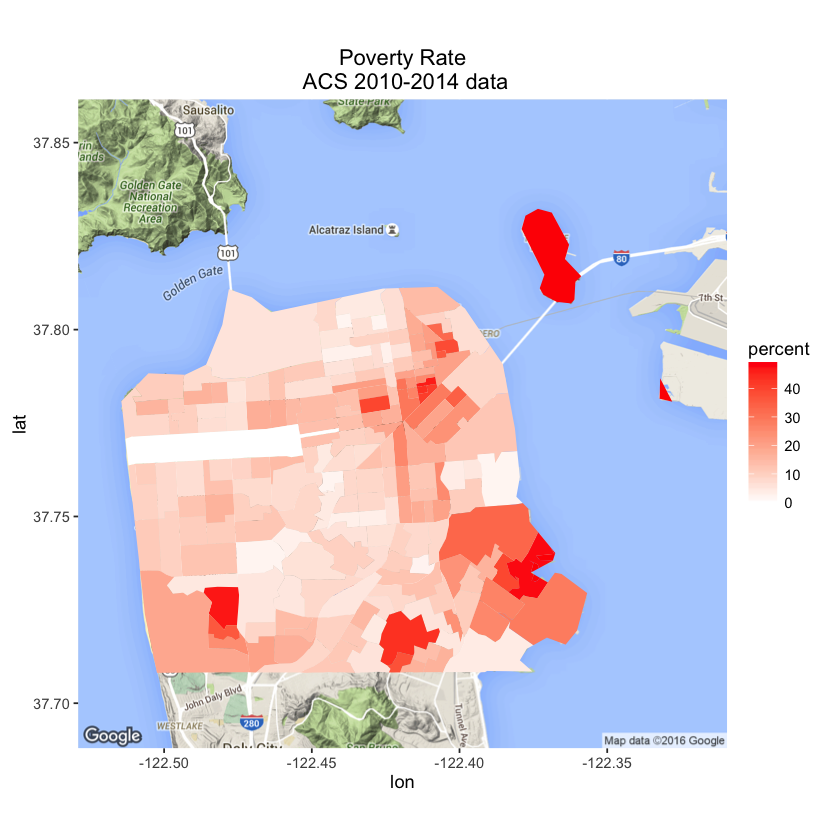

In [19]:

sf_basemap <-get_map('San Francisco', zoom=12) 
ggmap(sf_basemap) +
geom_polygon(data = ca_tract3 , aes(x=long, y=lat, group = group, fill=percent)) +
scale_fill_gradient(low="white",high="red") + 
ggtitle('Poverty Rate\n ACS 2010-2014 data')